In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('gemini_BTCUSD_2020_1min.csv')

BTC-2017min.csv contains all the 1 Minute historical data of 2020, this dataset contains columns including Unix Timestamp, dates, Symbol, opening, high, low, closing, Volume (Crypto) and Volume Base Ccy. code up your first kernel: LSTMs and Deep Reinforcement Learning agents works well for this dataset. Don't forget to up-vote 👍 **Currency in BTC-USD
<br>
About each Column:
<ul>
<li>Unix Timestamp - This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone</li>
<li>Date - This timestamp is UTC Timezone</li>
<li>Symbol - The symbol for which the timeseries data refers</li>
<li>Open - This is the opening price of the time period</li>
<li>High - This is the highest price of the time period</li>
<li>Low - This is the lowest price of the time period</li>
<li>Close - This is the closing price of the time period</li>
<li>Volume (Crypto) - This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount</li>

</ul>


In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [5]:
data = data.iloc[: , 3:]

In [6]:
data.head()

,Open,High,Low,Close,Volume
0,55717.47,55723.00,55541.69,55541.69,2.406734
1,55768.94,55849.82,55711.74,55717.47,0.573458
2,55691.79,55793.15,55691.79,55768.94,3.309904
3,55777.86,55777.86,55677.92,55691.79,0.684934
4,55803.50,55823.88,55773.08,55777.86,0.477225


In [7]:
data.shape

(658065, 5)

In [8]:
scaler = MinMaxScaler().fit(data)

In [9]:
Data = scaler.transform(data)

In [10]:
Data.shape

(658065, 5)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [12]:
class Data_Gen(Dataset):
    def __init__(self, data, window, prediction, step,min_index, max_index):
        self.data = data
        self.window = window
        self.prediction = prediction
        self.step = step
        self.min_index = min_index
        self.max_index = max_index
    def __len__(self):
        return (self.max_index - self.min_index - self.window - self.prediction - 1)
    def __getitem__(self, index):
        start_index = index + self.min_index
        end_index = start_index + self.window
        indices = range(start_index, end_index, self.step)

        samples = np.zeros((len(indices), 4))  # Assuming 4 features (columns)
        
        for j, idx in enumerate(indices):
            samples[j] = self.data[idx, 1:]  # Features from columns 1 onward
        
        targets = self.data[idx + self.prediction, 0]  # Target is column 0
        samples = torch.from_numpy(samples).float()
        targets = torch.tensor(targets, dtype=torch.float32)  # Convert scalar to tensor

        return samples, targets

In [13]:
window = 1440
predcition = 10
step = 1
batch = 32


In [14]:
Train_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index =200000, max_index=300000)
Val_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index =300000, max_index=400000)
Test_dataset = Data_Gen(data = Data, window =window, prediction = predcition,step= step, min_index = 400001,max_index= 500000)

In [15]:
Train_loader = DataLoader(Train_dataset, batch_size = batch, shuffle = True)
Val_loader = DataLoader(Val_dataset, batch_size = batch, shuffle = True)
Test_loader = DataLoader(Test_dataset, batch_size = batch, shuffle = True)

In [16]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.gru1 = nn.GRU(4, 32, batch_first=True, bidirectional= False , num_layers = 1)
        self.gru2 = nn.GRU(32, 32, batch_first = True)
        self.flat = nn.Flatten()
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
       out1, out2 = self.gru1(x)
       out1, out2 = self.gru2(out1)
       out = self.flat(out2.squeeze())
       out = self.dense(out)

       return out

In [17]:
rnn1 = RNN1()


In [18]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv1d(4, 64, kernel_size=7)  # Input channels = 4 (from features), output channels = 64
        self.max_pool1 = nn.MaxPool1d(kernel_size=5)  
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)  # Second conv layer
        self.max_pool2 = nn.MaxPool1d(kernel_size=5) 

        self.gru1 = nn.GRU(128, 64, batch_first=True, bidirectional=False, num_layers=1)  # Input size = 128 (CNN output channels)
        self.gru2 = nn.GRU(64, 32, batch_first=True)

        self.flat = nn.Flatten()
        self.dense = nn.Linear(32, 1)  # Output a single value (regression)

    def forward(self, x):
        # CNN layers
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len) for Conv1d
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)

        # GRU layers
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, input_size) for GRU
        out1, _ = self.gru1(x)
        _, out2 = self.gru2(out1)

        # Flatten and Dense layer
        # out = self.flat(out2[:, -1, :])  # Use the last GRU output
        # out = self.dense(out)
        out = self.flat(out2.squeeze())
        out = self.dense(out)

        return out


In [19]:
model = CNN1()

In [20]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Training using the CNN with RNN model

In [34]:
num_epochs = 20
steps_per_epoch = 40  # Number of batches to process in each epoch

# Initialize lists to store loss values
train_losses = []
val_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    trainning_loss = 0.0
    for idx, (samples, targets) in enumerate(Train_loader):
        if idx == steps_per_epoch:
            break  # Stop after processing 40 batches
        optimizer.zero_grad()  # Reset gradients
        predictions = model(samples)  # Forward pass
        loss = loss_function(predictions, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        trainning_loss += loss.item() 
    avg_train_loss = trainning_loss / steps_per_epoch
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for ix, (data, targets_val) in enumerate(Val_loader):
            if ix == steps_per_epoch:
                break  # Stop after processing 40 batches
            predictions_val = model(data)
            loss_ = loss_function(predictions_val, targets_val)
            val_loss += loss_.item()
    avg_val_loss =val_loss / steps_per_epoch
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



Epoch 1/20, Train Loss: 0.0021, Val Loss: 0.0027
Epoch 2/20, Train Loss: 0.0021, Val Loss: 0.0018
Epoch 3/20, Train Loss: 0.0021, Val Loss: 0.0022
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0031
Epoch 5/20, Train Loss: 0.0021, Val Loss: 0.0020
Epoch 6/20, Train Loss: 0.0022, Val Loss: 0.0023
Epoch 7/20, Train Loss: 0.0021, Val Loss: 0.0023
Epoch 8/20, Train Loss: 0.0021, Val Loss: 0.0020
Epoch 9/20, Train Loss: 0.0021, Val Loss: 0.0025
Epoch 10/20, Train Loss: 0.0021, Val Loss: 0.0030
Epoch 11/20, Train Loss: 0.0022, Val Loss: 0.0030
Epoch 12/20, Train Loss: 0.0021, Val Loss: 0.0026
Epoch 13/20, Train Loss: 0.0021, Val Loss: 0.0022
Epoch 14/20, Train Loss: 0.0021, Val Loss: 0.0025
Epoch 15/20, Train Loss: 0.0022, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0020, Val Loss: 0.0021
Epoch 17/20, Train Loss: 0.0020, Val Loss: 0.0025
Epoch 18/20, Train Loss: 0.0021, Val Loss: 0.0020
Epoch 19/20, Train Loss: 0.0021, Val Loss: 0.0017
Epoch 20/20, Train Loss: 0.0021, Val Loss: 0.0020


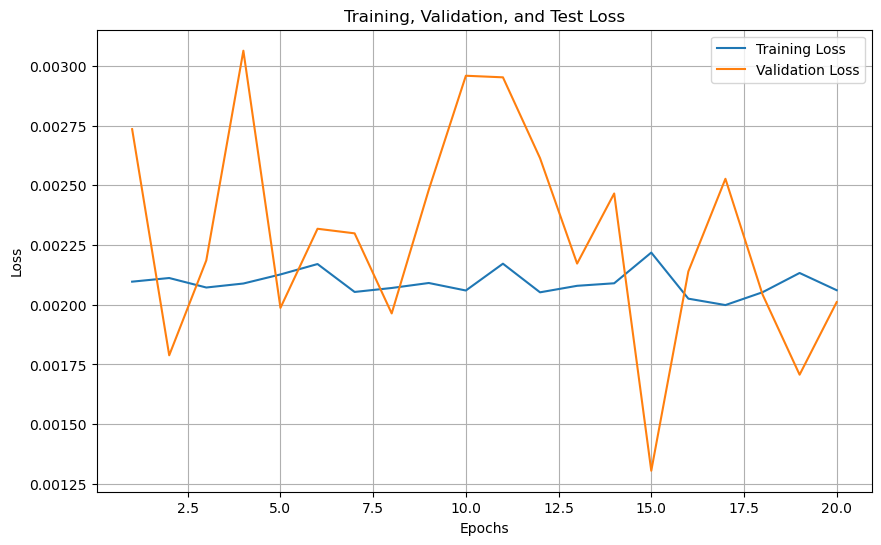

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for data_test, test_targets in Test_loader:
        test_prediction = model(data_test)  # Forward pass
        loss = loss_function(test_prediction, test_targets)  # Calculate the loss
        test_loss += loss.item()  # Accumulate the loss

# Average the test loss over all batches
avg_test_loss = test_loss/len(Test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.0046


## Tarining using the RNN model

In [23]:
num_epochs = 10
steps_per_epoch = 40  # Number of batches to process in each epoch
for epoch in range(num_epochs):
    model.train()
    trainning_loss = 0.0
    for idx, (samples, targets) in enumerate(Train_loader):
        if idx == steps_per_epoch:
            break  # Stop after processing 40 batches
        optimizer.zero_grad()  # Reset gradients
        predictions = rnn1(samples)  # Forward pass
        loss = loss_function(predictions, targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        trainning_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {trainning_loss / steps_per_epoch:.4f}")


c:\Users\laboh\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.0580
Epoch 2, Loss: 0.0577
Epoch 3, Loss: 0.0581
Epoch 4, Loss: 0.0575
Epoch 5, Loss: 0.0583
Epoch 6, Loss: 0.0590
Epoch 7, Loss: 0.0579
Epoch 8, Loss: 0.0581
Epoch 9, Loss: 0.0591
Epoch 10, Loss: 0.0577
